In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import string
import re

from wordcloud import WordCloud
from PIL import Image

import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import seaborn as sns
 
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stopwords = stopwords.words('english')
#from src.confusion import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettzimmerman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('phase-4-dataset.csv', encoding= 'latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


# Data Cleaning

In [3]:
df = df.dropna(axis=0, subset=['tweet_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


Renaming Columns

In [4]:
new_stopwords = ["sxsw", "android", "google", "apple", "ipad", "app", "austin", 'iphone']
punctuations = string.punctuation
stopwords.extend(new_stopwords)
stopwords.extend(punctuations)

In [5]:
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "emotion"}, inplace=True)
df.rename(columns={"emotion_in_tweet_is_directed_at" : "product"}, inplace=True)

Adding a label encoder to our target column

In [6]:
le = LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])
df.head()

,tweet_text,product,emotion,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


In [7]:
df['label'].value_counts(normalize=True)

2    0.592609
3    0.327541
1    0.062692
0    0.017158
Name: label, dtype: float64

Seeing how many labels we're working with here

In [8]:
df.drop(df[df['label']==0].index, inplace = True)
df['label'].value_counts(normalize=True)

2    0.602954
3    0.333259
1    0.063787
Name: label, dtype: float64

## Functions For Text Preprocessing

In [9]:
#Create a function to clean the Tweets with Regex
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    text = re.sub(r'&quot', '', str(text)) # remove quote symbol
    text = re.sub(r'&amp', '', str(text)) # remove and symbol
    return text

In [10]:
df['model_text'] = df['tweet_text'].apply(remove_junk)
df.head()

,tweet_text,product,emotion,label,model_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1,. I have a 3G iPhone. After 3 hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3,Know about ? Awesome iPad/iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3,Can not wait for iPad 2 also. They should sal...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1,I hope this year's festival isn't as crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3,great stuff on Fri SXSW: Marissa Mayer (Googl...


In [11]:
#Create a function that tokenizes text
def tokenize(text):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(text)
    tweet_tokens = [word.lower() for word in tokenized_tweet]
    return tweet_tokens

In [12]:
#Create a function that removes stopwords and punctuation
def remove_sw_punct(tweet_tokens):
    tweets_clean = [word for word in tweet_tokens if word not in stopwords]
    return tweets_clean

In [13]:
stemmer = PorterStemmer()

def stemming(tweets_clean):
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]         
    return tweets_stem

In [14]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    return tweets_stem

In [15]:
tweet_example = df['tweet_text'][0]
print(tweet_example)

processed_tweet = process_tweet(tweet_example)
print(processed_tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['g', 'hr', 'tweet', 'rise', 'dead', 'need', 'upgrad', 'plugin', 'station']


In [16]:
df['processed_tweet'] = [process_tweet(i) for i in df['tweet_text']]
df['machine_tweet'] = [' '.join(i) for i in df['processed_tweet']]

In [17]:
df.head()

,tweet_text,product,emotion,label,model_text,processed_tweet,machine_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1,. I have a 3G iPhone. After 3 hrs tweeting at ...,"[g, hr, tweet, rise, dead, need, upgrad, plugi...",g hr tweet rise dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3,Know about ? Awesome iPad/iPhone app that yo...,"[know, awesom, like, appreci, design, also, gi...",know awesom like appreci design also give free ts
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3,Can not wait for iPad 2 also. They should sal...,"[wait, also, sale]",wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1,I hope this year's festival isn't as crashy a...,"[hope, year, festiv, crashi, year]",hope year festiv crashi year
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3,great stuff on Fri SXSW: Marissa Mayer (Googl...,"[great, stuff, fri, marissa, mayer, tim, reill...",great stuff fri marissa mayer tim reilli tech ...


In [18]:
data_neg = df['processed_tweet'].loc[df['label'] == 1]

negative_sentiment = []
for i in data_neg:
    listToStr = ' '.join(map(str, i))
    negative_sentiment.append(listToStr)
negative_sentiment = ' '.join(map(str,  negative_sentiment))


In [19]:
data_pos = df['processed_tweet'].loc[df['label'] == 3]

positive_sentiment = []
for i in data_pos:
    listToStr = ' '.join(map(str, i))
    positive_sentiment.append(listToStr)
positive_sentiment = ' '.join(map(str,  positive_sentiment))

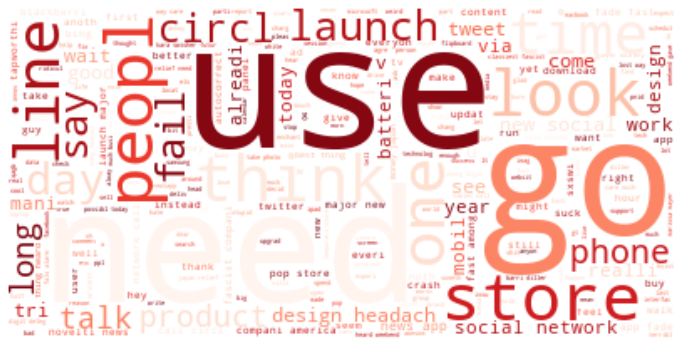

In [20]:
# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='Reds'
)
# generate the word cloud
wc.generate(negative_sentiment)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

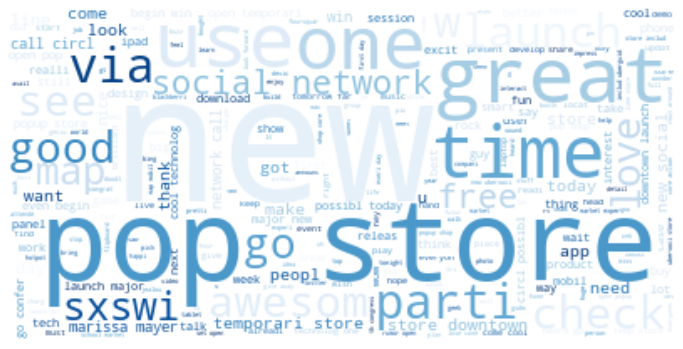

In [21]:
# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='Blues'
)
# generate the word cloud
wc.generate(positive_sentiment)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

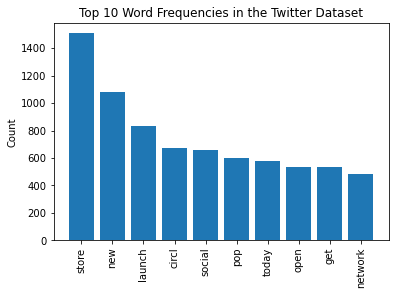

In [22]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
freq_dist = FreqDist(df['processed_tweet'].explode())

# Plot the top 10 tokens
visualize_top_10(freq_dist, "Top 10 Word Frequencies in the Twitter Dataset")

# Train Test Split

In [23]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .9)

# Baseline Model Using a Dummy Classifier

In [24]:
dum_pipe = Pipeline([('count', CountVectorizer()),
                    ('model', DummyClassifier(strategy='stratified'))])

model = dum_pipe.fit(X_train['model_text'], y_train)

y_trn_pred = dum_pipe.predict(X_train['model_text'])
y_tst_pred = dum_pipe.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.06      0.06      0.06       513
           2       0.61      0.61      0.61      4849
           3       0.34      0.34      0.34      2680

    accuracy                           0.48      8042
   macro avg       0.34      0.34      0.34      8042
weighted avg       0.48      0.48      0.48      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.04      0.04      0.04        57
           2       0.61      0.62      0.61       539
           3       0.34      0.34      0.34       298

    accuracy                           0.49       894
   macro avg       0.33      0.33      0.33       894
weighted avg       0.48      0.49      0.48       894



# Grid Search on Multinomial NB

In [25]:
tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
    ('smt', SMOTE(random_state=30)),
    ('mnb', MultinomialNB()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.75, 0.90),
    'tfidf__min_df': (2, 3),
    'tfidf__ngram_range': [(1,1),(1, 2), (1, 3)],
    'tfidf__max_features': (10000, 70000, 85000),
    'tfidf__norm': ('l1', 'l2'),
    'mnb__alpha': (.005, .05, .5),
    'smt__k_neighbors' : (2,5)
    
}

grid_search = GridSearchCV(tf_nb_pipe, parameters, cv=2, n_jobs=2, verbose=3, scoring = 'f1_macro')
grid_search.fit(X_train['model_text'], y_train)

tf_nb_best = grid_search.best_estimator_

y_trn_pred = tf_nb_best.predict(X_train['model_text'])
y_tst_pred = tf_nb_best.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:   46.1s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 1296 out of 1296 | elapsed:  4.3min finished


		The Train Results
              precision    recall  f1-score   support

           1       0.57      0.96      0.71       513
           2       0.91      0.81      0.86      4849
           3       0.77      0.82      0.80      2680

    accuracy                           0.82      8042
   macro avg       0.75      0.86      0.79      8042
weighted avg       0.84      0.82      0.83      8042


		The Test Results
              precision    recall  f1-score   support

           1       0.29      0.56      0.38        57
           2       0.76      0.66      0.71       539
           3       0.57      0.61      0.59       298

    accuracy                           0.63       894
   macro avg       0.54      0.61      0.56       894
weighted avg       0.67      0.63      0.65       894



In [26]:
tf_nb_best

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, max_features=10000, min_df=2,
                                 ngram_range=(1, 2), norm='l1',
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenize at 0x15d60d550>)),
                ('smt', SMOTE(k_neighbors=2, random_state=30)),
                ('mnb', MultinomialNB(alpha=0.05))])

In [27]:
def predict(pipeline, text):
    # Predict the sentiment
    #textdata = pipeline.transform()
    text = [remove_junk(i) for i in text]
    sentiment = pipeline.predict(text)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([1,2,3], ['Negative', 'Neutral', 'Positive'])
    return df

In [28]:
tweets = ["I hate Google", "My ipad is broken", "Nate will be give a speech today.", "I'm excited to go the Apple store"]
predictions = predict(tf_nb_best, tweets)
print(predictions)

                                text sentiment
0                      I hate Google  Negative
1                  My ipad is broken  Negative
2  Nate will be give a speech today.   Neutral
3  I'm excited to go the Apple store  Positive


# Trying out different Models

# Bernoulli NB

In [29]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words=stopwords, tokenizer=tokenize)
vectoriser.fit(X_train['model_text'])
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  5000


In [30]:
X_train_vec = vectoriser.transform(X_train['model_text'])
X_test_vec  = vectoriser.transform(X_test['model_text'])

In [31]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train_vec, y_train)

BernoulliNB(alpha=2)

In [32]:
y_pred = BNBmodel.predict(X_test_vec)

print(classification_report(y_test, y_pred))
    
cf_matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.45      0.09      0.15        57
           2       0.71      0.82      0.76       539
           3       0.58      0.51      0.54       298

    accuracy                           0.67       894
   macro avg       0.58      0.47      0.48       894
weighted avg       0.65      0.67      0.65       894



# Logistic Regression

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_vec, y_train)

y_pred = LRmodel.predict(X_test_vec)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.11      0.17        57
           2       0.71      0.86      0.78       539
           3       0.62      0.48      0.54       298

    accuracy                           0.68       894
   macro avg       0.60      0.48      0.50       894
weighted avg       0.66      0.68      0.66       894



# In The End, MultiNomialNB Gave the Best Results

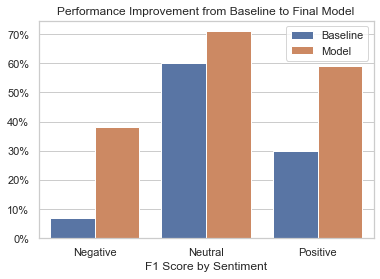

In [34]:
sns.set_theme(style="whitegrid")
graph_results = {'Score': [.07, .6, .3, .38, .71, .59], 'Sentiment': ['Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive'], 'Model': ['Baseline', 'Baseline', 'Baseline', 'Model', 'Model', 'Model']}
ax = sns.barplot(x="Sentiment", y="Score", hue="Model", data=graph_results)
ax.set_title("Performance Improvement from Baseline to Final Model")
ax.set_xlabel("F1 Score by Sentiment");
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))